In [1]:
# -----------------------------
# Space Biology QA Pipeline
# -----------------------------

import os
import re
from dotenv import load_dotenv
from typing_extensions import List, TypedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

from langchain import hub
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model
from qdrant_client import QdrantClient
from langchain_mistralai import MistralAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph

In [2]:
# -----------------------------
# Load environment variables
# -----------------------------
load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# -----------------------------
# Initialize Qdrant Client and Embeddings
# -----------------------------
collection_name = "task_proyects"
client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

embeddings = MistralAIEmbeddings(model="mistral-embed")

store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings
)

# -----------------------------
# Load Prompts and LLM
# -----------------------------
prompt_manager_latest = hub.pull("pruebanasa/manager_latest")
llm = init_chat_model("open-mixtral-8x7b", model_provider="mistralai")

d:\proyectos_de_desarrollo\nasa\NASA_Nexus\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\proyectos_de_desarrollo\nasa\NASA_Nexus\venv\Lib\site-packages\pydantic\main.py:253: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [3]:
# -----------------------------
# Pipeline State
# -----------------------------
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    summary: str

# -----------------------------
# Document Retrieval
# -----------------------------
def retrieve_agent_manager(state: dict, k=15) -> dict:
    """
    Retrieves the top-k most relevant  project documents (for Manager profile)
    from Qdrant and builds a concise summary including project scope, funding info,
    progress, and Earth/space impact.
    """
    retrieved_docs = store.similarity_search(query=state["question"], k=k)

    if not retrieved_docs:
        print("[retrieve_manager] No relevant projects found.")
        return {"context": [], "summary": "No relevant projects found."}

    summary_blocks = []
    for i, doc in enumerate(retrieved_docs, start=1):
        meta = doc.metadata or {}

        # --- Safe extraction of fields ---
        project_title = meta.get("project_title", "Untitled")
        fiscal_year = meta.get("fiscal_year", "Unknown")
        division = meta.get("division", "Unknown")
        responsible_center = meta.get("project_information", {}).get("responsible_center", "Unknown")
        principal_investigator = meta.get("principal_investigator", {}).get("name", "Not specified")
        grant_monitor = meta.get("project_information", {}).get("grant_monitor", "Unknown")
        start_date = meta.get("start_date", "Unknown")
        end_date = meta.get("end_date", "Unknown")
        funding_source = meta.get("project_information", {}).get("solicitation__funding_source", "Unknown")
        grant_no = meta.get("project_information", {}).get("grantcontract_no", "Unknown")
        link = meta.get("pdf_download_link", "N/A")

        task_description = (
            meta.get("project_information", {}).get("task_description", "")
            or "No project description available."
        )
        task_progress = (
            meta.get("task_progress_and_bibliography", {}).get("task_progress", "")
            or "No progress report available."
        )
        earth_benefits = (
            meta.get("project_information", {}).get("research_impact/earth_benefits", "")
            or "No Earth benefits described."
        )

        # --- Build formatted text block ---
        info = f"""Project {i}
Title: {project_title}
Division: {division}
Fiscal Year: {fiscal_year}
Responsible Center: {responsible_center}
Principal Investigator: {principal_investigator}
Grant Monitor: {grant_monitor}
Start Date: {start_date}
End Date: {end_date}
Funding Source: {funding_source}
Grant/Contract No.: {grant_no}
Link: {link}

Description:
{task_description}

Progress Summary:
{task_progress}

Impact and Earth Benefits:
{earth_benefits}
"""
        summary_blocks.append(info.strip())
    summary_text = "\n\n---\n\n".join(summary_blocks)
    print(f"[retrieve_manager] Retrieved {len(retrieved_docs)} relevant projects.")
    return {
        "context": retrieved_docs,
        "summary": summary_text
    }


# -----------------------------
# Generate final answer
# -----------------------------
def generate(state: State) -> State:
    """
    Genera la respuesta final basada en los documentos recuperados.
    """
    context = state.get("summary", [])

    # Preparar prompt para investigador
    messages = prompt_manager_latest.invoke({
        "question": state["question"],
        "context": context
    })

    response = llm.invoke(messages)
    answer = response.content.strip()

    state.update({
        "answer": answer
    })
    return state

# -----------------------------
# Pipeline Construction
# -----------------------------
graph_builder = StateGraph(State).add_sequence([
    retrieve_agent_manager,   # Recupera documentos relevantes
    generate    # Genera respuesta final
])

graph_builder.add_edge(START, "retrieve_agent_manager")
graph = graph_builder.compile()

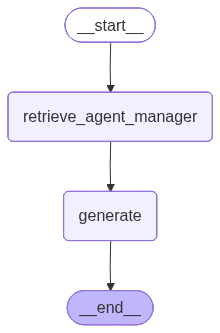

In [4]:
# -----------------------------
# Visualize pipeline (optional)
# -----------------------------
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# -----------------------------
# Example Queries
# -----------------------------
question_example_1 = "Does the response clearly identify high-impact research areas, measurable outcomes, and emerging opportunities relevant to NASA’s bioscience goals?"
question_example_2 = "Is the information presented in a way that supports decision-making — concise, structured, and emphasizing impact, collaboration, and funding opportunities rather than technical detail?"

response = graph.invoke({"question": question_example_1})
print("\nFinal Answer:")
print(response["answer"])

[retrieve_manager] Retrieved 15 relevant projects.

Final Answer:
**Executive Summary**

The reviewed documents highlight various research areas in space biology, with an emphasis on the impact of spaceflight on organisms and Earth. Studies show that spaceflight affects gene expression, cellular processes, and microbial communities in plants and animals. There are also indications that spaceflight-induced changes may have applications in human health and agriculture on Earth.

**Impact Highlights**

1. [1] Demonstrates that spaceflight affects gene expression in Arabidopsis, with implications for understanding plant adaptation to novel environments and potential benefits for Earth-based agriculture.
2. [2] Investigates the effects of spaceflight on human immune cells, revealing changes that could inform countermeasures for astronaut health and potentially improve immune function on Earth.
3. [3] Reveals the potential for spaceflight to alter microbial communities and their functions, w